In [1]:
from models import MeshModel, IcosphereModel
import jax.numpy as jnp
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity
import astropy.units as u

In [2]:
u.solRad.to(u.cm)

69570000000.0

In [3]:
m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([3.75]), jnp.ones(19)]))

In [16]:
mt = add_rotation(m, 20.*1e5, jnp.array([1., 1., 0.]))
mt = evaluate_rotation(mt, 0.)

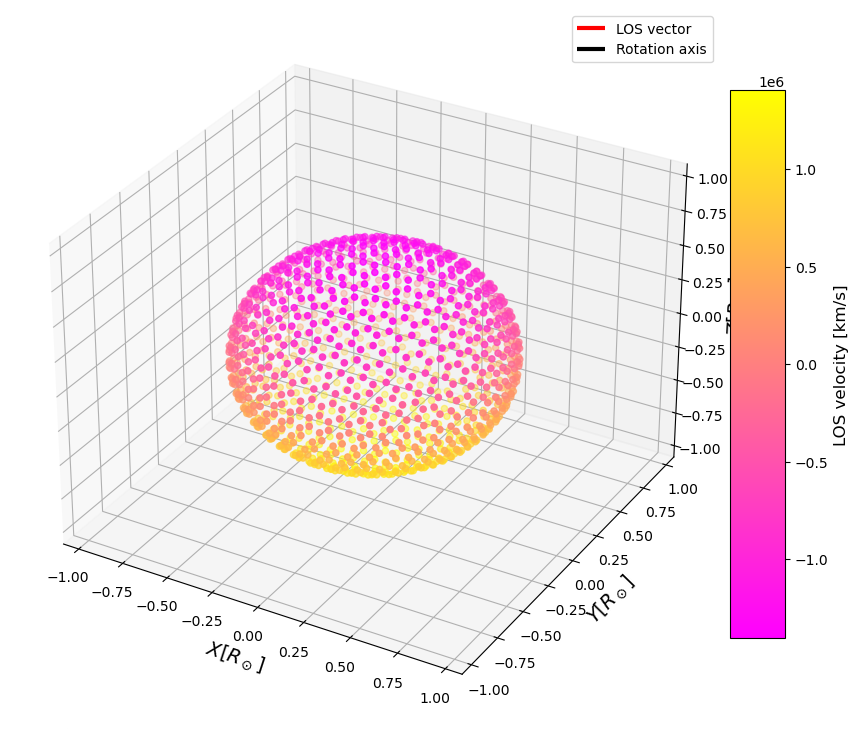

In [17]:
plot_3D(mt, 'los_velocities', cmap='spring')

In [ ]:
mt1 = evaluate_rotation(mt, 0)

In [ ]:
jnp.max(mt1.los_velocities)

Array(987.57904, dtype=float32)

In [ ]:
jnp.max(mt1.velocities)

Array(992.7091, dtype=float32)

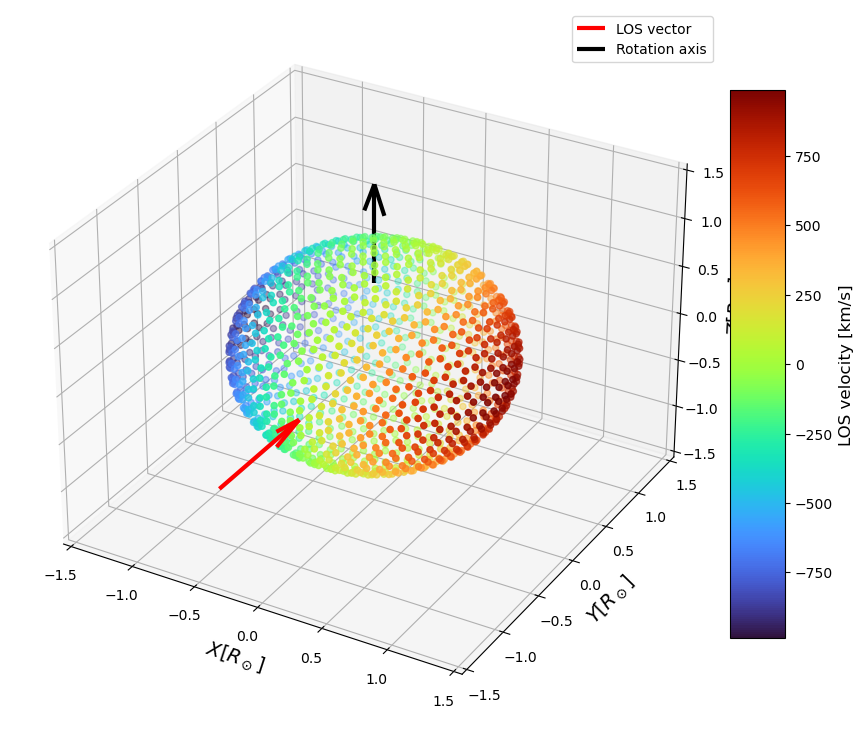

In [ ]:
plot_3D(mt1, 'los_velocities')

In [ ]:
mt1.parameters.shape

(1280, 20)

In [ ]:
i = simulate_spectrum(blackbody_intensity, mt1, jnp.log10(jnp.linspace(1000., 20000., 100)))

In [ ]:
import matplotlib.pyplot as plt

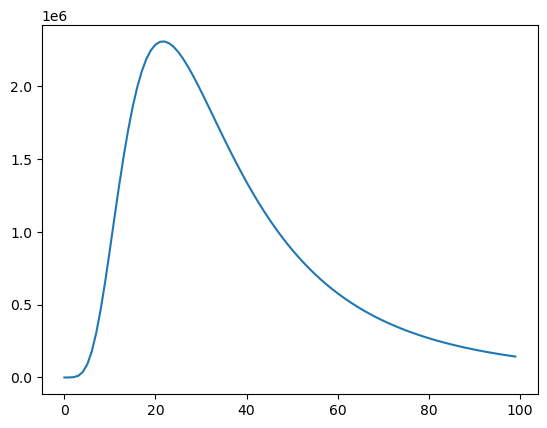

In [ ]:
plt.plot(i[:, 0])